In [11]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, LSTM, Flatten, Dropout, Bidirectional
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from deap import base, creator, tools, algorithms
import random


In [55]:
data= pd.read_csv("cardio_train.csv",delimiter=";")

In [56]:
data.head(2)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1


In [57]:
# 1a. Drop any column named 'id' (case-insensitive)
id_cols = [col for col in data.columns if col.lower() == 'id']
if id_cols:
    data.drop(columns=id_cols, inplace=True)

# 2. Rename Columns (for easier handling)
data.rename(columns={
    'age': 'age_days',       # Original age column is in days
    'gender': 'gender',
    'height': 'height_cm',
    'weight': 'weight_kg',
    'ap_hi': 'systolic_bp',
    'ap_lo': 'diastolic_bp',
    'cholesterol': 'cholesterol',
    'gluc': 'glucose',
    'smoke': 'smoke',
    'alco': 'alcohol',
    'active': 'physical_activity',
    'cardio': 'cardio'
}, inplace=True)

# 3. Data Type Conversion and Correction
# Convert age from days to years and ensure non-negative ages
data['age'] = (data['age_days'] / 365.25).astype(int)
data = data[data['age'] >= 0]  # Remove any rows with negative ages
data.drop('age_days', axis=1, inplace=True)

# Map gender (assuming original coding: 1 = female, 2 = male)
# The mapping below sets: female -> 0, male -> 1
data['gender'] = data['gender'].map({1: 0, 2: 1})

# 4. Handling Outliers and Impossible Values (before scaling)
# Blood Pressure: Use realistic human ranges
data = data[(data['systolic_bp'] > 70) & (data['systolic_bp'] < 200)]
data = data[(data['diastolic_bp'] > 40) & (data['diastolic_bp'] < 140)]

# Height and Weight: Use realistic ranges (in cm and kg)
data = data[(data['height_cm'] > 100) & (data['height_cm'] < 250)]
data = data[(data['weight_kg'] > 30) & (data['weight_kg'] < 200)]

# Cholesterol and Glucose: Allow only the defined valid values (typically 1, 2, or 3)
data = data[data['cholesterol'].isin([1, 2, 3])]
data = data[data['glucose'].isin([1, 2, 3])]

# 5. Feature Engineering
# Calculate BMI
data['bmi'] = data['weight_kg'] / ((data['height_cm'] / 100) ** 2)
# Remove BMI outliers (a reasonable range)
data = data[(data['bmi'] > 15) & (data['bmi'] < 50)]

# Create a blood pressure stage feature
def bp_stage(systolic, diastolic):
    if systolic < 120 and diastolic < 80:
        return 'Normal'
    elif systolic < 130 and diastolic < 80:
        return 'Elevated'
    else:
        return 'High'

data['blood_pressure_stage'] = data.apply(
    lambda row: bp_stage(row['systolic_bp'], row['diastolic_bp']),
    axis=1
)

# Create an age group feature
def age_group(age):
    if age < 40:
        return 'Young'
    elif age < 60:
        return 'Middle-Aged'
    else:
        return 'Senior'

data['age_group'] = data['age'].apply(age_group)

# 6. Encoding Categorical Features
# One-hot encode the blood pressure stage and age group.
# Using drop_first=True to avoid multicollinearity.
data = pd.get_dummies(data, columns=['blood_pressure_stage', 'age_group'], drop_first=True)

# 7. Scaling Numerical Features
# Note: We exclude the binary 'gender' so that it remains 0/1.
numerical_cols = ['height_cm', 'weight_kg', 'systolic_bp', 'diastolic_bp', 'bmi', 'age']
scaler = StandardScaler()
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])

# If you prefer to scale gender as well, include it:
# numerical_cols = ['height_cm', 'weight_kg', 'systolic_bp', 'diastolic_bp', 'bmi', 'age', 'gender']
# data[numerical_cols] = scaler.fit_transform(data[numerical_cols])

# 8. Display the Cleaned Data
print("Head of the cleaned DataFrame:")
print(data.head())

print("\nDataFrame info:")
print(data.info())

print("\nDescriptive statistics:")
print(data.describe())

Head of the cleaned DataFrame:
   gender  height_cm  weight_kg  systolic_bp  diastolic_bp  cholesterol  \
0       1   0.453003  -0.859442    -1.009118     -0.135230            1   
1       0  -1.077141   0.793604     0.831662      0.936567            3   
2       0   0.070467  -0.715699     0.218069     -1.207027            3   
3       1   0.580515   0.577989     1.445256      2.008364            1   
4       0  -1.077141  -1.290671    -1.622712     -2.278824            1   

   glucose  smoke  alcohol  physical_activity  cardio       age       bmi  \
0        1      0        0                  1       0 -0.411669 -1.075208   
1        1      0        0                  1       1  0.327301  1.499956   
2        1      0        0                  0       1 -0.263875 -0.769086   
3        1      0        0                  1       1 -0.707257  0.264646   
4        1      0        0                  0       0 -0.855051 -0.867762   

   blood_pressure_stage_High  blood_pressure_stage_Norm

In [58]:
data.head(2)


,gender,height_cm,weight_kg,systolic_bp,diastolic_bp,cholesterol,glucose,smoke,alcohol,physical_activity,cardio,age,bmi,blood_pressure_stage_High,blood_pressure_stage_Normal,age_group_Senior,age_group_Young
0,1,0.453003,-0.859442,-1.009118,-0.135230,1,1,0,0,1,0,-0.411669,-1.075208,True,False,False,False
1,0,-1.077141,0.793604,0.831662,0.936567,3,1,0,0,1,1,0.327301,1.499956,True,False,False,False


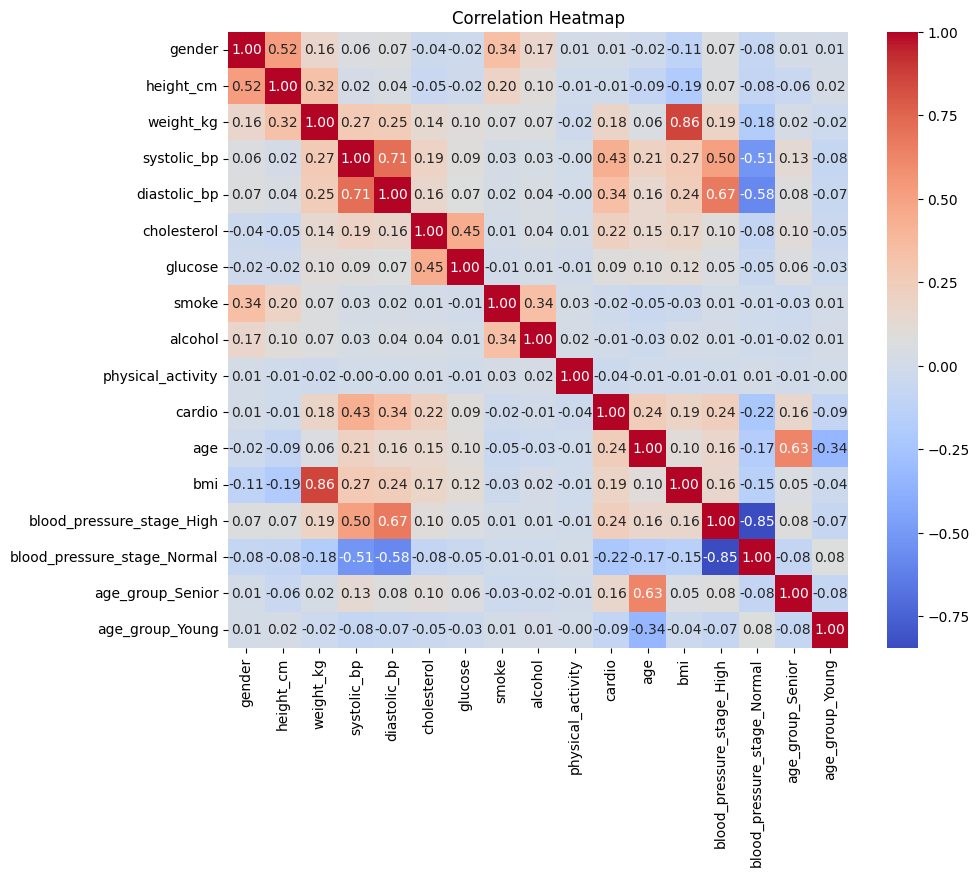

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns
# -----------------------------
# 2. Correlation Heatmap
# -----------------------------
plt.figure(figsize=(10, 8))
# Compute correlation matrix for numerical features only
corr_matrix = data.corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()


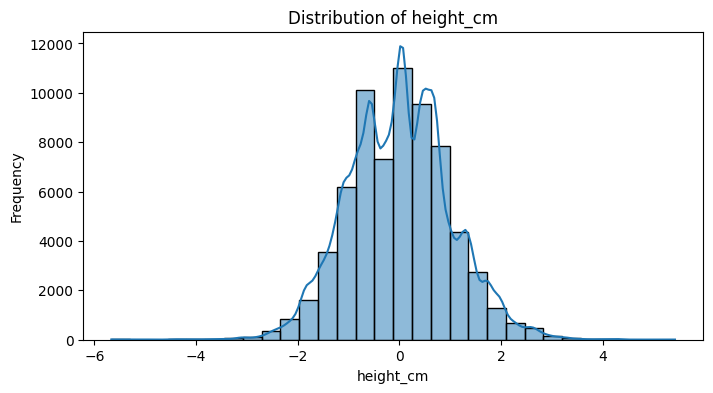

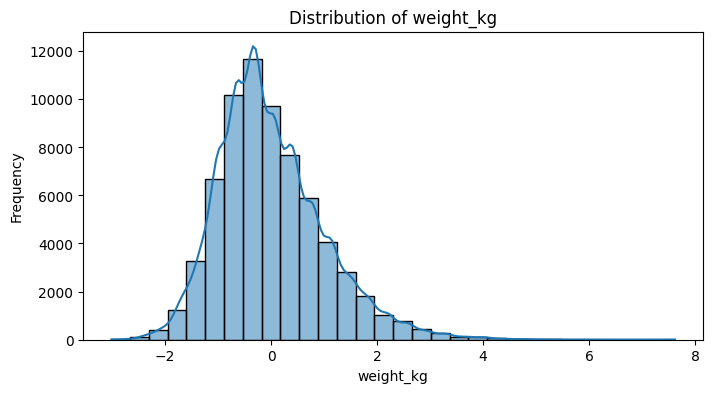

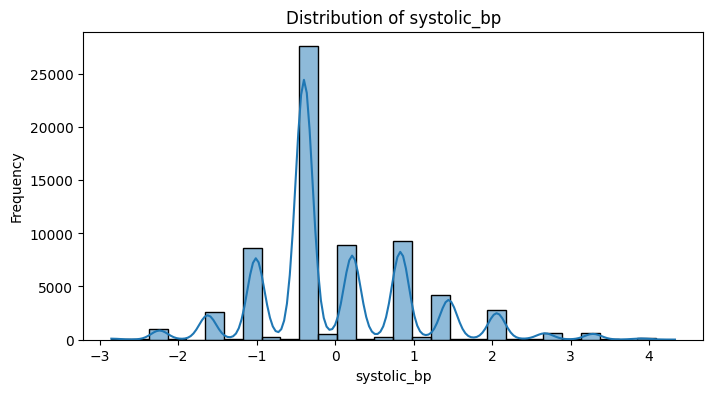

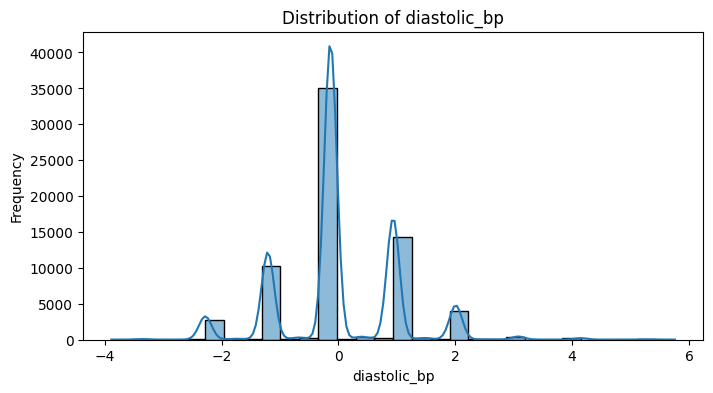

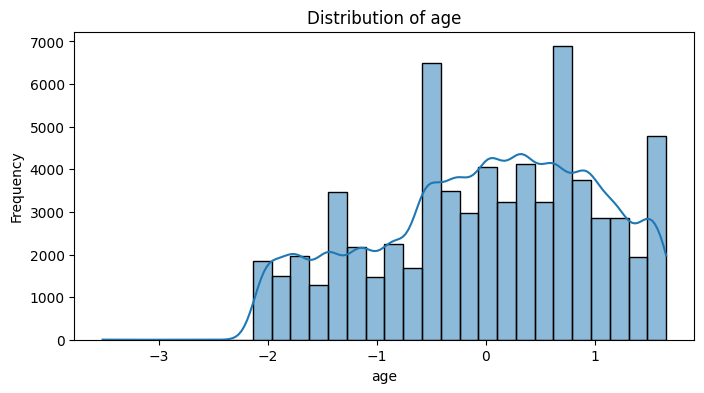

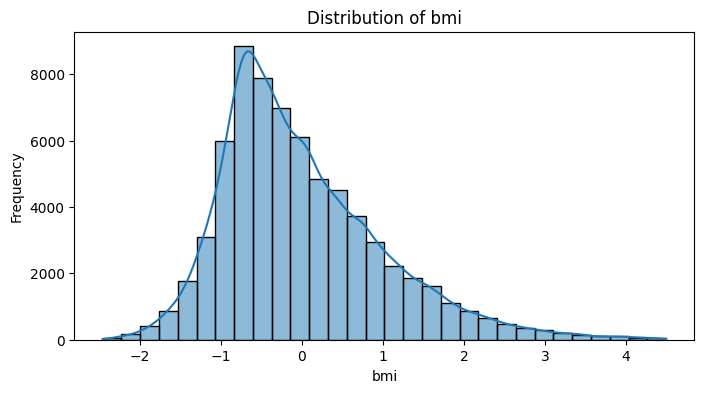

In [60]:
# -----------------------------
# 3. Distribution Plots for Continuous Features
# -----------------------------
# Define your continuous features (these are assumed to be scaled)
continuous_features = ['height_cm', 'weight_kg', 'systolic_bp', 'diastolic_bp', 'age', 'bmi']

for feature in continuous_features:
    plt.figure(figsize=(8, 4))
    sns.histplot(data[feature], kde=True, bins=30)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel("Frequency")
    plt.show()

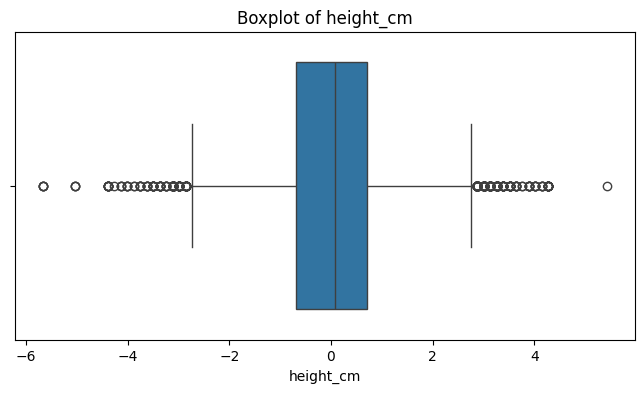

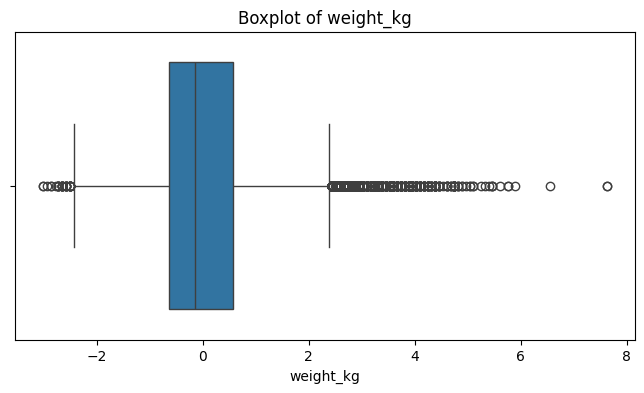

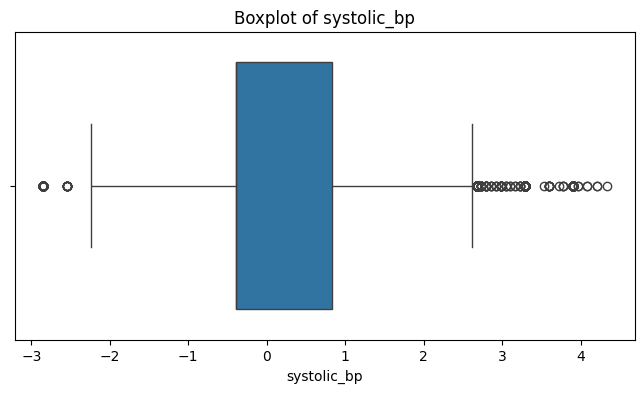

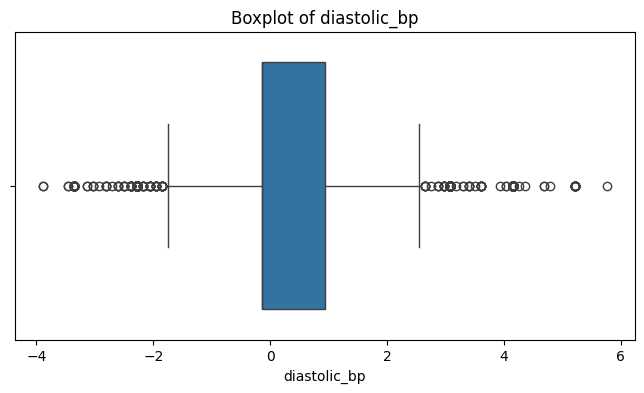

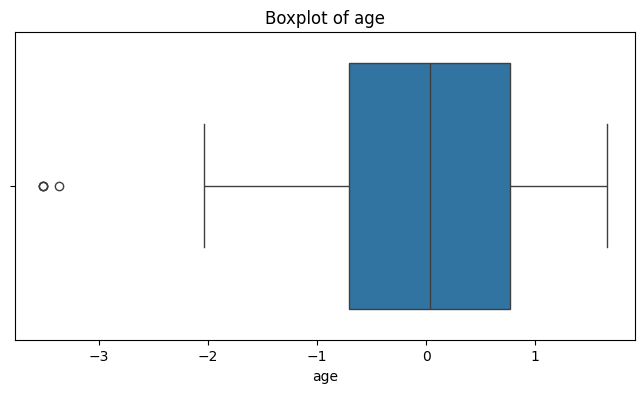

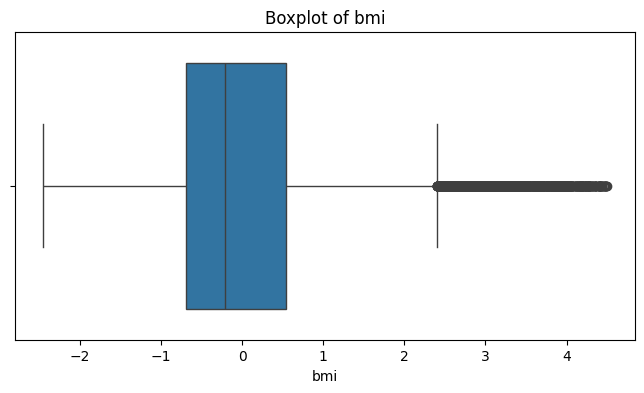

In [61]:
# -----------------------------
# 4. Boxplots for Continuous Features
# -----------------------------
for feature in continuous_features:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=data[feature])
    plt.title(f'Boxplot of {feature}')
    plt.xlabel(feature)
    plt.show()


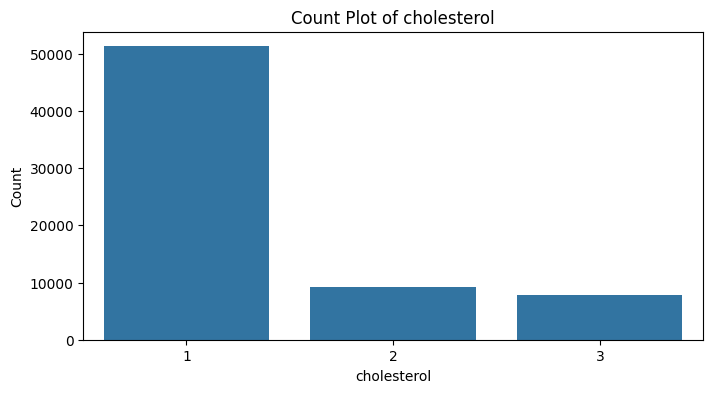

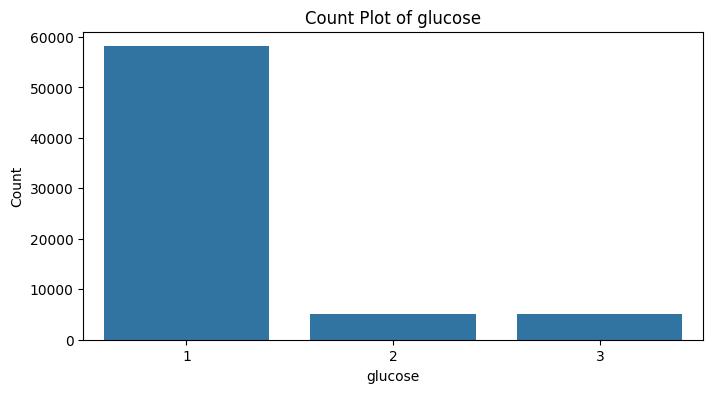

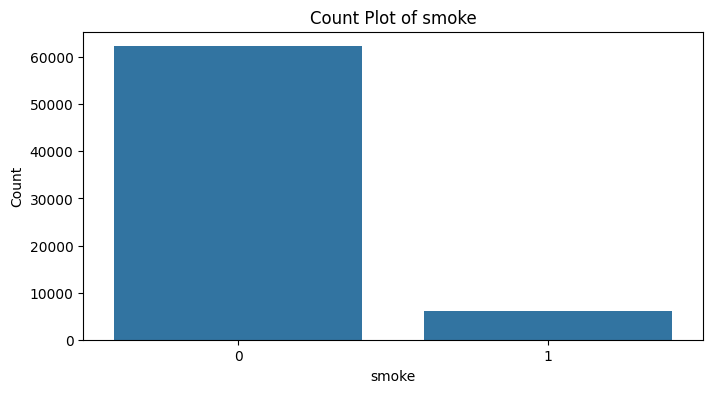

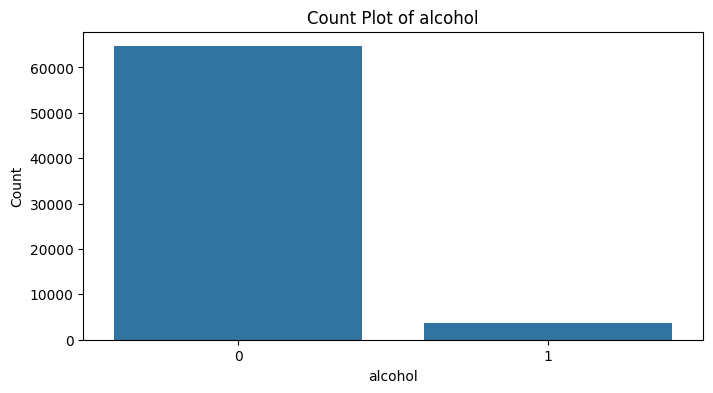

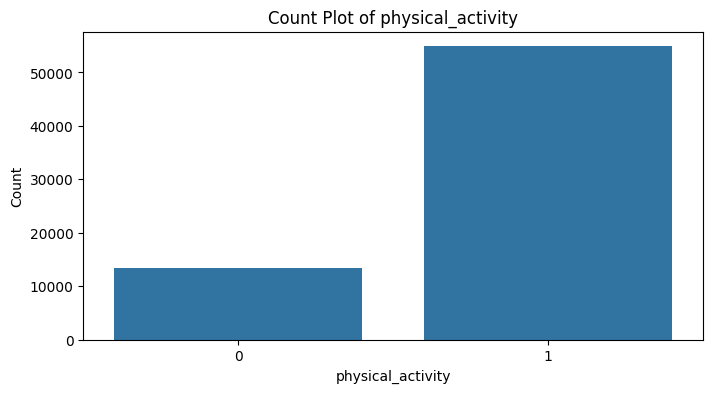

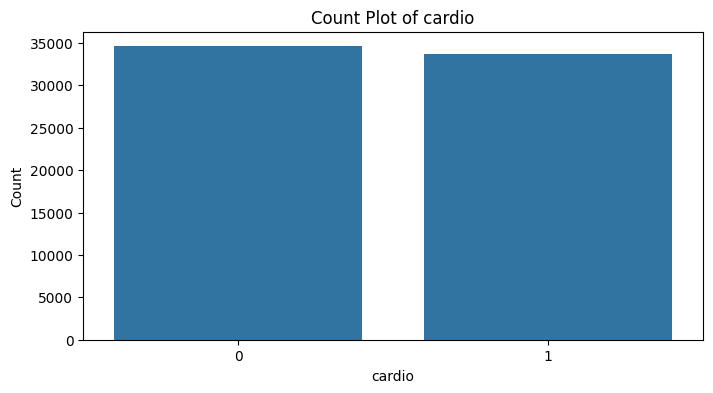

In [62]:
# -----------------------------
# 5. Count Plots for Categorical Features
# -----------------------------
# Define your categorical features
# These might include your original categorical variables, such as:
categorical_features = ['cholesterol', 'glucose', 'smoke', 'alcohol', 'physical_activity', 'cardio']

for feature in categorical_features:
    plt.figure(figsize=(8, 4))
    sns.countplot(x=data[feature])
    plt.title(f'Count Plot of {feature}')
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.show()

In [72]:
# ===============================
# 2. Prepare Data for the LSTM Model
# ===============================

# Separate features and target (assuming 'cardio' is the target)
X = data.drop(columns=['cardio']).values.astype(np.float32)
y = data['cardio'].values

# Reshape X into a 3D array for the LSTM: (samples, timesteps, features)
# Here, we use a single timestep.
X = X.reshape(X.shape[0], 1, X.shape[1])

# Split data into training (70%), validation (15%), and test (15%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)


In [73]:
# ===============================
# 3. Define the LSTM Model Function
# ===============================

def create_lstm_model(input_shape, lstm_units, dropout_rate, learning_rate):
    inputs = tf.keras.Input(shape=input_shape)
    x = LSTM(lstm_units, return_sequences=False)(inputs)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model


In [74]:
# ===============================
# 4. Define the Objective Function
# ===============================

def objective_function(params):
    """
    Train the LSTM model with given hyperparameters and return negative validation accuracy.
    Parameters:
      params (list or array): [lstm_units, dropout_rate, learning_rate]
    """
    lstm_units = int(params[0])
    dropout_rate = params[1]
    learning_rate = params[2]
    
    model = create_lstm_model(input_shape=X_train.shape[1:],
                              lstm_units=lstm_units,
                              dropout_rate=dropout_rate,
                              learning_rate=learning_rate)
    
    early_stop = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True, verbose=0)
    
    model.fit(X_train, y_train,
              validation_data=(X_val, y_val),
              epochs=30,
              batch_size=32,
              verbose=0,
              callbacks=[early_stop])
    
    val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
    print(f"Params: LSTM units = {lstm_units}, dropout = {dropout_rate:.3f}, lr = {learning_rate:.5f} => Val Acc: {val_acc:.4f}")
    
    # Return negative validation accuracy for minimization.
    return -val_acc


In [76]:
# ===============================
# 5. AEO DLENN Optimization (Conceptual Implementation)
# ===============================

def aeo_dlenn_optimization(objective_func, bounds, population_size=20, iterations=30):
    """
    A conceptual implementation of the AEO DLENN optimization.
    
    Parameters:
      objective_func: Function evaluating a candidate hyperparameter set.
      bounds: List of (min, max) tuples for each hyperparameter.
      population_size: Number of candidate solutions.
      iterations: Number of iterations to run.
    
    Returns:
      best_candidate: Best hyperparameters found.
      best_obj_value: Best (lowest) objective function value.
    """
    dim = len(bounds)
    # Initialize population uniformly within bounds with explicit numeric dtype.
    population = np.array([[np.random.uniform(low, high) for (low, high) in bounds]
                           for _ in range(population_size)], dtype=np.float64)
    
    best_candidate = None
    best_obj_value = float('inf')
    
    for it in range(iterations):
        for i in range(population_size):
            candidate = population[i]
            obj_value = objective_func(candidate)
            if obj_value < best_obj_value:
                best_obj_value = obj_value
                best_candidate = candidate.copy()
        print(f"Iteration {it+1}/{iterations}: Best objective = {best_obj_value:.4f}")
        
        # --- Population Update (Random Perturbation as a Placeholder) ---
        perturbation = np.random.uniform(-0.05, 0.05, population.shape)
        population = population + perturbation
        
        # Enforce bounds for each parameter.
        for j, (low, high) in enumerate(bounds):
            population[:, j] = np.clip(population[:, j], low, high)
            
    return best_candidate, best_obj_value

In [ ]:
# ===============================
# 6. Hyperparameter Optimization
# ===============================

# Define the search bounds:
#   lstm_units: between 16 and 128
#   dropout_rate: between 0.0 and 0.5
#   learning_rate: between 1e-5 and 1e-2
bounds = [(16, 128), (0.0, 0.5), (1e-5, 1e-2)]

best_params, best_obj_value = aeo_dlenn_optimization(objective_function, bounds,
                                                     population_size=20,
                                                     iterations=6)
print("Best hyperparameters found:", best_params)
print("Best validation accuracy achieved:", -best_obj_value)

Params: LSTM units = 19, dropout = 0.084, lr = 0.00668 => Val Acc: 0.7318
Params: LSTM units = 105, dropout = 0.157, lr = 0.00984 => Val Acc: 0.7306
Params: LSTM units = 87, dropout = 0.400, lr = 0.00973 => Val Acc: 0.7302
Params: LSTM units = 82, dropout = 0.055, lr = 0.00372 => Val Acc: 0.7301
Params: LSTM units = 119, dropout = 0.070, lr = 0.00006 => Val Acc: 0.7267
Params: LSTM units = 66, dropout = 0.164, lr = 0.00321 => Val Acc: 0.7286
Params: LSTM units = 49, dropout = 0.235, lr = 0.00317 => Val Acc: 0.7297
Params: LSTM units = 47, dropout = 0.282, lr = 0.00692 => Val Acc: 0.7300
Params: LSTM units = 38, dropout = 0.436, lr = 0.00685 => Val Acc: 0.7286
Params: LSTM units = 58, dropout = 0.275, lr = 0.00760 => Val Acc: 0.7308
Params: LSTM units = 42, dropout = 0.084, lr = 0.00618 => Val Acc: 0.7323
Params: LSTM units = 26, dropout = 0.494, lr = 0.00358 => Val Acc: 0.7273
Params: LSTM units = 66, dropout = 0.443, lr = 0.00101 => Val Acc: 0.7282
Params: LSTM units = 101, dropout = 

In [ ]:
# ===============================
# 7. Train the Final Model with Best Hyperparameters
# ===============================

best_lstm_units = int(best_params[0])
best_dropout_rate = best_params[1]
best_learning_rate = best_params[2]

final_model = create_lstm_model(input_shape=X_train.shape[1:],
                                lstm_units=best_lstm_units,
                                dropout_rate=best_dropout_rate,
                                learning_rate=best_learning_rate)

final_early_stop = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, verbose=1)
final_history = final_model.fit(X_train, y_train,
                                validation_data=(X_val, y_val),
                                epochs=100,
                                batch_size=32,
                                verbose=1,
                                callbacks=[final_early_stop])

# Evaluate the final model on the test set.
final_loss, final_acc = final_model.evaluate(X_test, y_test)
print("Test accuracy:", final_acc)

In [ ]:
final_model.save("final_model.h5")